# Flower Species Classification with EfficientNetB0

This notebook builds a transfer-learning pipeline for the Flowers-102 dataset using EfficientNetB0. It trains in two phases (feature extraction + fine-tuning), reports top-1 and top-5 accuracy, and visualizes results.

## 1. Setup and Configuration

In [3]:
import torch

print("Torch version:", torch.__version__)
print("Torch CUDA version:", torch.version.cuda)
if torch.version.cuda != "12.9":
    raise RuntimeError("CUDA 12.9 is required for this run.")
if "dev" not in torch.__version__:
    raise RuntimeError("PyTorch nightly is required for this run.")
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. GPU-only training required.")

print("GPU:", torch.cuda.get_device_name(0))
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

Torch version: 2.12.0.dev20260217+cu129
Torch CUDA version: 12.9
GPU: NVIDIA GeForce RTX 5060 Laptop GPU


In [4]:
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_WORKERS = 4

In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import EfficientNet_B0_Weights
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def accuracy_topk(outputs: torch.Tensor, targets: torch.Tensor, topk=(1, 5)):
    with torch.no_grad():
        maxk = max(topk)
        _, pred = outputs.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(targets.view(1, -1).expand_as(pred))
        results = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0)
            results.append(correct_k)
        return results

def ensure_cuda_or_fail(stage: str) -> None:
    if not torch.cuda.is_available():
        raise RuntimeError(f"CUDA is required for {stage}, but is not available.")

print("=" * 60)
print("PYTORCH STARTUP")
print("=" * 60)
print("✓ GPU-only training enabled")
print("=" * 60)

PYTORCH STARTUP
✓ GPU-only training enabled


## 2. Load and Explore the Flowers-102 Dataset

In [6]:
data_dir = Path("dataset")
train_dir = data_dir / "train"
valid_dir = data_dir / "valid"
test_dir = data_dir / "test"

if not train_dir.exists() or not valid_dir.exists() or not test_dir.exists():
    raise FileNotFoundError(
        "Expected dataset splits at dataset/train, dataset/valid, dataset/test. "
        "Please place the Flowers-102 images in that structure."
    )

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
mean = weights.meta.get("mean", [0.485, 0.456, 0.406])
std = weights.meta.get("std", [0.229, 0.224, 0.225])

train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(IMG_SIZE[0], scale=(0.9, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(36),
        transforms.ColorJitter(contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
 )

eval_transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
 )

test_has_subdirs = any(p.is_dir() for p in test_dir.iterdir())

class_names = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])
num_classes = len(class_names)
print("Classes:", num_classes)
print("Example class names:", class_names[:10])

Classes: 102
Example class names: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15']


In [7]:
def count_images(root_dir: Path) -> int:
    return sum(1 for _ in root_dir.rglob("*.*"))

print("Train images:", count_images(train_dir))
print("Valid images:", count_images(valid_dir))
print("Test images:", count_images(test_dir))

# Visualize a few samples
viz_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])
viz_ds = datasets.ImageFolder(train_dir, transform=viz_transform)
viz_loader = DataLoader(viz_ds, batch_size=9, shuffle=True, num_workers=0, pin_memory=False)
images, labels = next(iter(viz_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.title(viz_ds.classes[int(labels[i])])
    plt.axis("off")
plt.tight_layout()

Train images: 6552
Valid images: 818
Test images: 819


KeyboardInterrupt: 

## 3. Create Data Pipeline with tf.data

In [ ]:
# PERFORMANCE-OPTIMIZED DATA PIPELINE
train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
valid_ds = datasets.ImageFolder(valid_dir, transform=eval_transform)

if test_has_subdirs:
    test_ds = datasets.ImageFolder(test_dir, transform=eval_transform)
else:
    test_ds = None
    print("Test folder has no class subfolders; using validation set for evaluation.")

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=NUM_WORKERS > 0,
 )
valid_loader = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=NUM_WORKERS > 0,
 )
test_loader = (
    DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=NUM_WORKERS > 0,
    )
    if test_ds is not None
    else None
 )

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(valid_ds)}")

Test folder has no class subfolders; using validation set for evaluation.
Training dataset size: 6552
Validation dataset size: 818


In [ ]:
print("=" * 60)
print("GPU USAGE VERIFICATION")
print("=" * 60)

ensure_cuda_or_fail("GPU verification")
x = torch.randn(1000, 1000, device=device)
y = torch.matmul(x, x)
_ = y.float().mean().item()
print("✓ Successfully performed tensor operation on GPU")

sample_images, sample_labels = next(iter(train_loader))
print(f"\n✓ Training batch shape: {sample_images.shape}")
print(f"  Expected: (32, 3, 224, 224)")

if sample_images.shape[0] != BATCH_SIZE:
    print(f"  ⚠ WARNING: Batch size is {sample_images.shape[0]}, expected {BATCH_SIZE}")

print("\n" + "=" * 60)
print("Ready to train! Monitor GPU usage:")
print("  • nvidia-smi (in terminal)")
print("=" * 60)

GPU USAGE VERIFICATION
✓ Successfully performed tensor operation on GPU

✓ Training batch shape: torch.Size([32, 3, 224, 224])
  Expected: (32, 3, 224, 224)

Ready to train! Monitor GPU usage:
  • nvidia-smi (in terminal)


## 4. Implement Data Augmentation

In [ ]:
# Data augmentation (applied in the training transform)
print("Train transform:")
print(train_transform)
print("\nEval transform:")
print(eval_transform)

Train transform:
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-36.0, 36.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=None, contrast=(0.9, 1.1), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Eval transform:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## 5. Build EfficientNet Transfer Learning Model

In [ ]:
ensure_cuda_or_fail("model creation")

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
base_model = models.efficientnet_b0(weights=weights)
for param in base_model.features.parameters():
    param.requires_grad = False

class EfficientNetFlowers(nn.Module):
    def __init__(self, backbone: nn.Module, num_classes: int):
        super().__init__()
        self.features = backbone.features
        self.avgpool = backbone.avgpool
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.Linear(1280, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = EfficientNetFlowers(base_model, num_classes).to(device)
print(model)
print("\n✓ Preprocessing handled by torchvision transforms")
print("✓ Mixed precision enabled via torch.cuda.amp")

EfficientNetFlowers(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNorm

## 6. Phase 1: Feature Extraction Training

In [ ]:
output_dir = Path("models")
output_dir.mkdir(parents=True, exist_ok=True)

criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    correct1 = 0.0
    correct5 = 0.0
    total = 0
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        total += images.size(0)
        acc1, acc5 = accuracy_topk(outputs, targets, topk=(1, 5))
        correct1 += acc1.item()
        correct5 += acc5.item()
    avg_loss = running_loss / total
    top1 = correct1 / total
    top5 = correct5 / total
    return avg_loss, top1, top5

def eval_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    correct1 = 0.0
    correct5 = 0.0
    total = 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            total += images.size(0)
            acc1, acc5 = accuracy_topk(outputs, targets, topk=(1, 5))
            correct1 += acc1.item()
            correct5 += acc5.item()
    avg_loss = running_loss / total
    top1 = correct1 / total
    top5 = correct5 / total
    return avg_loss, top1, top5

ensure_cuda_or_fail("phase 1 training")

EPOCHS_PHASE1 = 20
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=3)

history_phase1 = {"loss": [], "accuracy": [], "top5": [], "val_loss": [], "val_accuracy": [], "val_top5": []}
best_val_acc = 0.0
epochs_no_improve = 0
patience = 5

for epoch in range(EPOCHS_PHASE1):
    train_loss, train_acc1, train_acc5 = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc1, val_acc5 = eval_one_epoch(model, valid_loader)
    scheduler.step(val_loss)

    history_phase1["loss"].append(train_loss)
    history_phase1["accuracy"].append(train_acc1)
    history_phase1["top5"].append(train_acc5)
    history_phase1["val_loss"].append(val_loss)
    history_phase1["val_accuracy"].append(val_acc1)
    history_phase1["val_top5"].append(val_acc5)

    print(
        f"Epoch {epoch + 1}/{EPOCHS_PHASE1} | "
        f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
        f"train_acc={train_acc1:.4f} val_acc={val_acc1:.4f} "
        f"train_top5={train_acc5:.4f} val_top5={val_acc5:.4f}"
    )

    if val_acc1 > best_val_acc:
        best_val_acc = val_acc1
        epochs_no_improve = 0
        torch.save(
            {"model_state": model.state_dict(), "optimizer_state": optimizer.state_dict()},
            output_dir / "efficientnetb0_flowers.pth",
        )
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

/tmp/ipykernel_3907/2739130831.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_3907/2739130831.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3907/2739130831.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20 | train_loss=1.8328 val_loss=0.8139 train_acc=0.5722 val_acc=0.7946 train_top5=0.7804 val_top5=0.9523
Epoch 2/20 | train_loss=0.7024 val_loss=0.7027 train_acc=0.8013 val_acc=0.8130 train_top5=0.9568 val_top5=0.9462
Epoch 3/20 | train_loss=0.5825 val_loss=0.6218 train_acc=0.8306 val_acc=0.8276 train_top5=0.9678 val_top5=0.9597
Epoch 4/20 | train_loss=0.5094 val_loss=0.5535 train_acc=0.8503 val_acc=0.8484 train_top5=0.9730 val_top5=0.9633
Epoch 5/20 | train_loss=0.4898 val_loss=0.5542 train_acc=0.8547 val_acc=0.8460 train_top5=0.9788 val_top5=0.9719
Epoch 6/20 | train_loss=0.4739 val_loss=0.6194 train_acc=0.8626 val_acc=0.8313 train_top5=0.9789 val_top5=0.9670
Epoch 7/20 | train_loss=0.4428 val_loss=0.5999 train_acc=0.8730 val_acc=0.8325 train_top5=0.9844 val_top5=0.9694
Epoch 8/20 | train_loss=0.3958 val_loss=0.5595 train_acc=0.8816 val_acc=0.8667 train_top5=0.9858 val_top5=0.9609
Epoch 9/20 | train_loss=0.3176 val_loss=0.5337 train_acc=0.9048 val_acc=0.8594 train_top5=0.9893

## 7. Phase 2: Fine-tuning Training

In [ ]:
total_blocks = len(model.features)
fine_tune_at = int(total_blocks * 0.8)

for idx, layer in enumerate(model.features):
    requires_grad = idx >= fine_tune_at
    for param in layer.parameters():
        param.requires_grad = requires_grad

optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=3)

ensure_cuda_or_fail("phase 2 training")

EPOCHS_PHASE2 = 10
history_phase2 = {"loss": [], "accuracy": [], "top5": [], "val_loss": [], "val_accuracy": [], "val_top5": []}
best_val_acc = 0.0
epochs_no_improve = 0
patience = 5

for epoch in range(EPOCHS_PHASE2):
    train_loss, train_acc1, train_acc5 = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc1, val_acc5 = eval_one_epoch(model, valid_loader)
    scheduler.step(val_loss)

    history_phase2["loss"].append(train_loss)
    history_phase2["accuracy"].append(train_acc1)
    history_phase2["top5"].append(train_acc5)
    history_phase2["val_loss"].append(val_loss)
    history_phase2["val_accuracy"].append(val_acc1)
    history_phase2["val_top5"].append(val_acc5)

    print(
        f"Epoch {epoch + 1}/{EPOCHS_PHASE2} | "
        f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
        f"train_acc={train_acc1:.4f} val_acc={val_acc1:.4f} "
        f"train_top5={train_acc5:.4f} val_top5={val_acc5:.4f}"
    )

    if val_acc1 > best_val_acc:
        best_val_acc = val_acc1
        epochs_no_improve = 0
        torch.save(
            {"model_state": model.state_dict(), "optimizer_state": optimizer.state_dict()},
            output_dir / "efficientnetb0_flowers_finetuned.pth",
        )
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

torch.save(model.state_dict(), output_dir / "efficientnetb0_flowers_final.pth")

/tmp/ipykernel_3907/2739130831.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_3907/2739130831.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10 | train_loss=0.1809 val_loss=0.3866 train_acc=0.9446 val_acc=0.9059 train_top5=0.9956 val_top5=0.9853
Epoch 2/10 | train_loss=0.1618 val_loss=0.3477 train_acc=0.9498 val_acc=0.9095 train_top5=0.9971 val_top5=0.9878
Epoch 3/10 | train_loss=0.1454 val_loss=0.3342 train_acc=0.9542 val_acc=0.9156 train_top5=0.9974 val_top5=0.9890
Epoch 4/10 | train_loss=0.1232 val_loss=0.3407 train_acc=0.9606 val_acc=0.9169 train_top5=0.9974 val_top5=0.9878
Epoch 5/10 | train_loss=0.1113 val_loss=0.3335 train_acc=0.9623 val_acc=0.9218 train_top5=0.9991 val_top5=0.9841
Epoch 6/10 | train_loss=0.1167 val_loss=0.2951 train_acc=0.9641 val_acc=0.9291 train_top5=0.9988 val_top5=0.9878
Epoch 7/10 | train_loss=0.0958 val_loss=0.2965 train_acc=0.9708 val_acc=0.9315 train_top5=0.9983 val_top5=0.9902
Epoch 8/10 | train_loss=0.0913 val_loss=0.3073 train_acc=0.9721 val_acc=0.9254 train_top5=0.9986 val_top5=0.9902
Epoch 9/10 | train_loss=0.0868 val_loss=0.3006 train_acc=0.9724 val_acc=0.9291 train_top5=0.9986

## 8. Evaluate Model Performance

/tmp/ipykernel_3907/2297439810.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Eval split: validation
Loss: 0.3015
Top-1 accuracy: 0.9364
Top-5 accuracy: 0.9902


<Figure size 1000x1000 with 0 Axes>

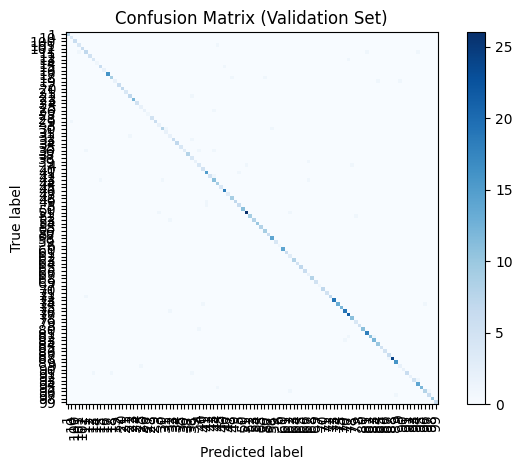

In [ ]:
eval_loader = test_loader if test_loader is not None else valid_loader
eval_name = "test" if test_loader is not None else "validation"

model.eval()
all_targets = []
all_preds = []
eval_loss = 0.0
correct1 = 0.0
correct5 = 0.0
total = 0

with torch.no_grad():
    for images, targets in eval_loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)
        eval_loss += loss.item() * images.size(0)
        total += images.size(0)
        acc1, acc5 = accuracy_topk(outputs, targets, topk=(1, 5))
        correct1 += acc1.item()
        correct5 += acc5.item()
        preds = torch.argmax(outputs, dim=1)
        all_targets.append(targets.cpu())
        all_preds.append(preds.cpu())

eval_loss = eval_loss / total
top1 = correct1 / total
top5 = correct5 / total

print(f"Eval split: {eval_name}")
print(f"Loss: {eval_loss:.4f}")
print(f"Top-1 accuracy: {top1:.4f}")
print(f"Top-5 accuracy: {top5:.4f}")

y_true = torch.cat(all_targets).numpy()
y_pred = torch.cat(all_preds).numpy()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=False, cmap="Blues", xticks_rotation="vertical")
plt.title(f"Confusion Matrix ({eval_name.title()} Set)")
plt.tight_layout()

## 9. Visualize Training History and Results

/tmp/ipykernel_3907/1438522393.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


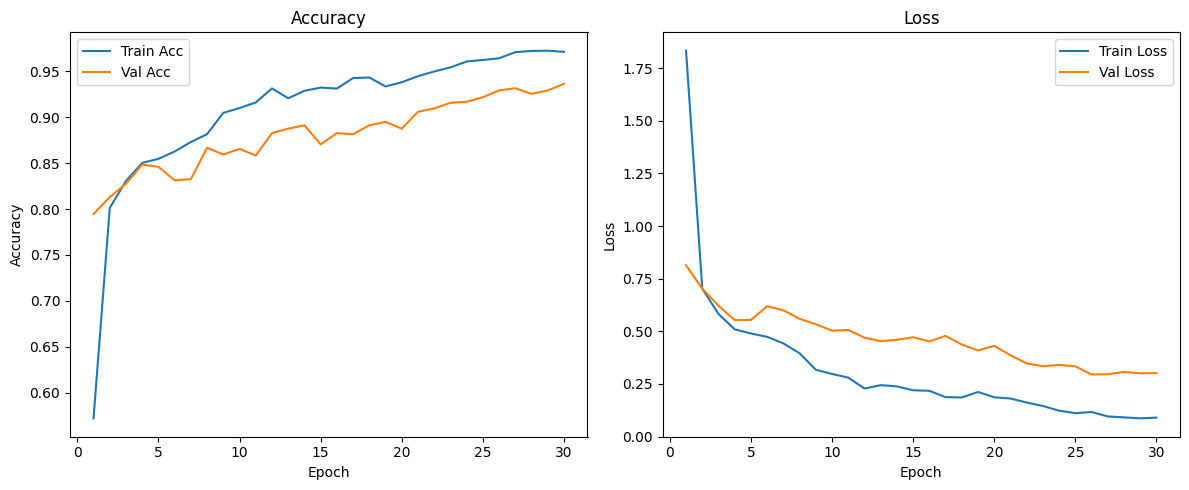

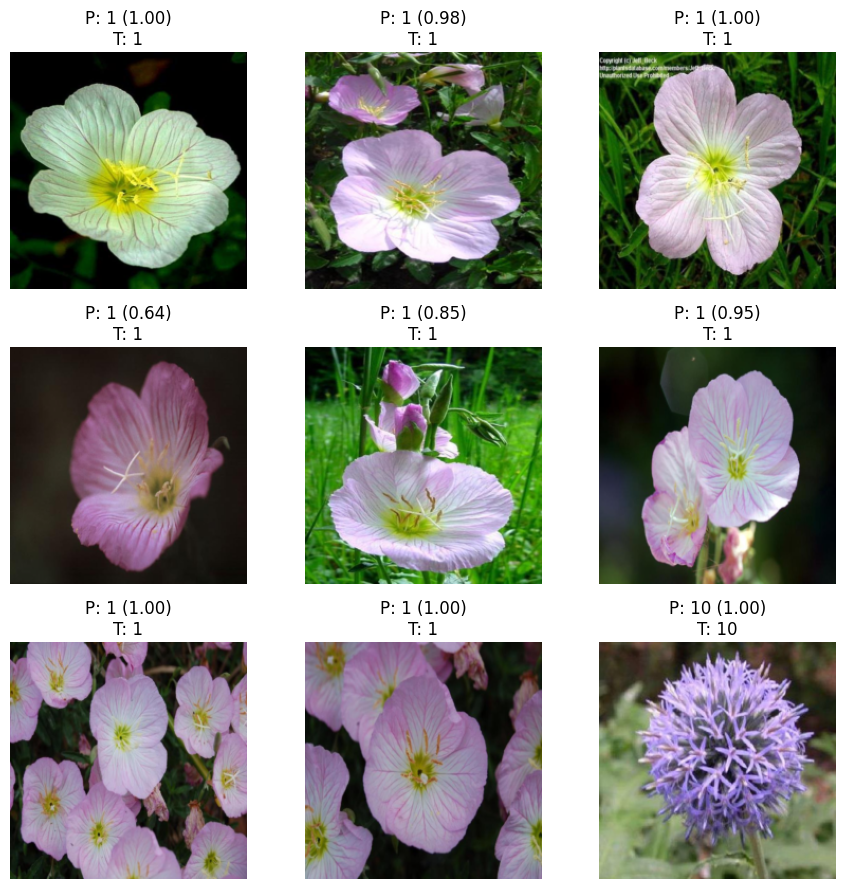

In [ ]:
def combine_histories(h1, h2):
    history = {}
    for key in h1:
        history[key] = h1[key] + h2.get(key, [])
    return history

combined = combine_histories(history_phase1, history_phase2)

epochs = range(1, len(combined["loss"]) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, combined["accuracy"], label="Train Acc")
plt.plot(epochs, combined["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, combined["loss"], label="Train Loss")
plt.plot(epochs, combined["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()

# Sample predictions
sample_loader = eval_loader
images, labels = next(iter(sample_loader))
images = images.to(device, non_blocking=True)
labels = labels.to(device, non_blocking=True)

with torch.no_grad():
    with autocast():
        logits = model(images)
    preds = torch.argmax(logits, dim=1)
    confidences = torch.softmax(logits, dim=1).max(dim=1).values

mean = torch.tensor(weights.meta.get("mean", [0.485, 0.456, 0.406])).to(device)
std = torch.tensor(weights.meta.get("std", [0.229, 0.224, 0.225])).to(device)
images = images * std[None, :, None, None] + mean[None, :, None, None]
images = images.clamp(0, 1).cpu()
labels = labels.cpu()
preds = preds.cpu()
confidences = confidences.cpu()

plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"P: {class_names[preds[i]]} ({confidences[i]:.2f})\nT: {class_names[labels[i]]}")
    plt.axis("off")
plt.tight_layout()

## 10. Predict Flower Category from Custom Image

In [ ]:
from ipywidgets import FileUpload, Output, VBox, Label
from IPython.display import display, Image as IPImage, clear_output
from PIL import Image as PILImage
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
from torchvision import transforms, models
from torchvision.models import EfficientNet_B0_Weights
import io
import json

# Load the category to name mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


def _sorted_class_names(cat_map):
    # Prefer numeric sorting when labels are numeric strings.
    try:
        return sorted(cat_map.keys(), key=lambda k: int(k))
    except (ValueError, TypeError):
        return sorted(cat_map.keys())


class_names = _sorted_class_names(cat_to_name)
num_classes = len(class_names)

# Set up device and preprocessing
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
mean = weights.meta.get("mean", [0.485, 0.456, 0.406])
std = weights.meta.get("std", [0.229, 0.224, 0.225])

eval_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class EfficientNetFlowers(nn.Module):
    def __init__(self, backbone: nn.Module, num_classes: int):
        super().__init__()
        self.features = backbone.features
        self.avgpool = backbone.avgpool
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.Linear(1280, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def _load_latest_model(model_dir: Path) -> Path:
    candidates = [
        model_dir / "efficientnetb0_flowers_final.pth",
        model_dir / "efficientnetb0_flowers_finetuned.pth",
        model_dir / "efficientnetb0_flowers.pth",
    ]
    for path in candidates:
        if path.exists():
            return path
    raise FileNotFoundError(
        "No saved model found in models/. Expected one of: "
        "efficientnetb0_flowers_final.pth, efficientnetb0_flowers_finetuned.pth, "
        "efficientnetb0_flowers.pth"
    )


# Build model and load weights
base_model = models.efficientnet_b0(weights=weights)
model = EfficientNetFlowers(base_model, num_classes).to(device)

model_path = _load_latest_model(Path("models"))
checkpoint = torch.load(model_path, map_location=device)

if isinstance(checkpoint, dict) and "model_state" in checkpoint:
    model.load_state_dict(checkpoint["model_state"])
else:
    model.load_state_dict(checkpoint)

model.eval()
print(f"Loaded model: {model_path}")

# Create file upload widget
file_upload = FileUpload(accept='image/*', multiple=False)
output_area = Output()


def _get_uploaded_bytes(upload_value):
    # Support ipywidgets 7 (dict) and 8 (tuple of UploadedFile)
    if isinstance(upload_value, dict):
        if not upload_value:
            return None
        uploaded_file = next(iter(upload_value.values()))
        return uploaded_file.get('content')

    if isinstance(upload_value, (list, tuple)):
        if not upload_value:
            return None
        uploaded_file = upload_value[0]
        if hasattr(uploaded_file, 'content'):
            return uploaded_file.content
        if isinstance(uploaded_file, dict):
            return uploaded_file.get('content')

    return None


def predict_flower(change):
    with output_area:
        clear_output(wait=True)

        file_content = _get_uploaded_bytes(file_upload.value)
        if not file_content:
            print("Please select an image file first.")
            return

        # Load image
        try:
            img = PILImage.open(io.BytesIO(file_content)).convert('RGB')
            print(f"Image loaded: {img.size}")
        except Exception as e:
            print(f"Error loading image: {e}")
            return

        # Display the uploaded image
        print("Uploaded Image:")
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Uploaded Image")
        plt.tight_layout()
        plt.show()

        # Preprocess the image
        img_preprocessed = eval_transform(img)
        img_batch = img_preprocessed.unsqueeze(0).to(device, non_blocking=True)

        # Make prediction
        use_amp = device.type == 'cuda'
        with torch.no_grad():
            if use_amp:
                with autocast():
                    logits = model(img_batch)
            else:
                logits = model(img_batch)
            probabilities = torch.softmax(logits, dim=1)[0]

        # Get top-1 and top-5 predictions
        top5_probs, top5_indices = torch.topk(probabilities, min(5, len(class_names)))

        print("\n" + "=" * 60)
        print("PREDICTION RESULTS")
        print("=" * 60)

        # Get the top prediction flower name
        top_class_idx = int(top5_indices[0])
        top_class_num = class_names[top_class_idx]
        top_flower_name = cat_to_name.get(top_class_num, top_class_num)

        print(f"\n🌸 Top Prediction: {top_flower_name.upper()} ({top5_probs[0]:.2%})")
        print("\nTop 5 Predictions:")
        print("-" * 60)
        for rank, (idx, prob) in enumerate(zip(top5_indices, top5_probs), 1):
            class_idx = int(idx)
            class_num = class_names[class_idx]
            flower_name = cat_to_name.get(class_num, class_num)
            confidence = float(prob) * 100
            bar_length = int(confidence / 5)
            bar = "█" * bar_length
            print(f"{rank}. {flower_name:<30} {confidence:>6.2f}% {bar}")
        print("=" * 60)


# Attach the prediction function to file upload changes
file_upload.observe(predict_flower, names='value')

# Create instructions label
instructions = Label(value="📤 Upload a flower image to get predictions")

# Display widgets
print("Flower Image Predictor")
print("=" * 60)
display(VBox([instructions, file_upload, output_area]))

Flower Image Predictor
